# Entropy Decomposition for Bimodal & Heteroskedastic Toy Datasets with samples from pymc3

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs

In [3]:
from utils.BNN_pymc3 import BNN_LV as BNN_LV_pymc3
from utils.custom_callbacks_pymc3 import plot95ci, wb_scatter, build_wb_callback

In [4]:
def plot_posterior_pred(bnn_in, X_train, y_train, X_test, w_samples):
    
    y_preds = []

    # Loop through the samples of weights
    for i in range(w_samples.shape[0]):
        # Create the same NN for predictions but with weights from the samples
        w_cur = w_samples[i,:]

        mu_pred = bnn_in.forward(X_test.reshape(-1,1), w_cur)
        y_pred = mu_pred
        y_preds.append(y_pred.reshape(-1))

    # Calculate percentiles
    y_lower = np.percentile(y_preds, q=2.5, axis=0)
    y_upper = np.percentile(y_preds, q=97.5, axis=0)
    y_med = np.percentile(y_preds, q=50, axis=0)

    # Plot with confidence
    plt.figure(figsize=(14,7))
    plt.scatter(X_train.flatten(), y_train.flatten(), color='black', label='data')
    plt.plot(X_test.flatten(), y_med, label="Median Prediction")
    plt.fill_between(X_test.flatten(), y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
    plt.title("Bayesian Neural Net Predictions with 95% CI - Bimodal")
    plt.xlabel("X Test")
    plt.ylabel("Y Predicted")
    plt.legend()
    plt.show()

In [5]:
import scipy as sp
import autograd.numpy as np

from scipy.spatial.distance import pdist, squareform

## Entropy calculation
def knn_entropy_2D(data_points, metric="euclidean"):
    """
    Inner function to which applies to calculation to each matrix (see knn_entropy for details)
    """
    # Set up constants 
    p = data_points.shape[1]
    n = data_points.shape[0]

    hypersphere_k = np.log( (np.pi ** (p/2)) / sp.special.gamma((p/2) + 1) )
    euler_k = np.euler_gamma + np.log(n-1)

    # Set the distance to self to infinity
    inf_diag = np.diag(np.ones(data_points.shape[0]) * np.inf)

    # Loop over each stack and calculate the entropy
    #for stack in data_points.shape[-1]

    # Create the distance matrix from point to all other points
    distances = squareform(pdist(data_points, metric)) + inf_diag

    # Closest neighbor distance
    p_i = np.min(distances, axis=1)

    # Calculate Entropy
    H = p * np.mean(np.log(p_i)) + hypersphere_k + euler_k

    return H


def knn_entropy(data_points, metric="euclidean"):
    """
    Utilize KNN approximation to calculate the entropy of a set of points.
    Data must be SxNxM where N = data points, M = dimensionality, S = stack 
    (as we are calculating entropy per datapoint S is usually going to be X)
    If distance are all zero (say a vector of ones) then returns -inf
    """
    assert(isinstance(data_points, np.ndarray)), "Error: Data must be a numpy 3D array (rows = data, columns = dimensions, depth=stacks)"
    assert(len(data_points.shape) == 3), "Error: Data must be a numpy 3D array (rows = data, columns = dimensions, depth=stacks)"

    H = np.stack([knn_entropy_2D(matrix) for matrix in data_points],axis=-1)

    return H


In [51]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## Heteroskedastic

In [6]:
y_hsc, X_hsc = generate_regression_outputs(type='hsc')

In [7]:
X_test_hsc = np.linspace(min(X_hsc), max(X_hsc), 100).reshape((1, -1))

In [8]:
# Parameters
gamma_hsc = 1
sigma_hsc = 1

architecture_hsc = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma_hsc],
             'sigma':[sigma_hsc]}

bnn_lv_hsc = BNN_LV_pymc3(architecture=architecture_hsc)

bnn_lv_hsc.fit(X_hsc, y_hsc, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 902.7824725452648; gradient mag: 1883.5166580296675
Iteration 500 lower bound 2.9757104454065595; gradient mag: 0.12206278791583665
Iteration 1000 lower bound 2.9366229984316123; gradient mag: 0.14754048121012472
Iteration 1500 lower bound 2.9216110817498873; gradient mag: 0.1435707061419706
Iteration 2000 lower bound 2.912183252429923; gradient mag: 0.24106087432274237
Iteration 2500 lower bound 2.9036021101622573; gradient mag: 1.1901244678131875
Iteration 3000 lower bound 2.890570151721035; gradient mag: 1.150734544517597
Iteration 3500 lower bound 2.8718371095452917; gradient mag: 1.8218411336665101
Iteration 4000 lower bound 2.8358501151098032; gradient mag: 0.7019677296397026
Iteration 4500 lower bound 2.8133003654314837; gradient mag: 2.011506050877773


In [13]:
het_samples_w = np.load('hsc/hsc_run_with_z_w_trace_target9_maxtree12.npy')

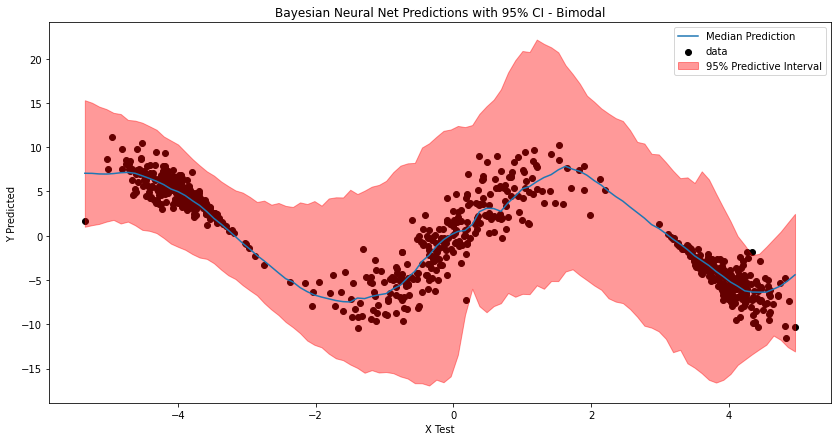

In [14]:
plot_posterior_pred(bnn_lv_hsc, X_hsc, y_hsc, X_test_hsc, het_samples_w)

### Decomposition

In [20]:
def decompose(bnn_lv, x_test_space, x_test_space_small, w_random_samples, S, N, N2, D):
    L = 100 # Number of y points to take per set of samples for epistemic uncertainty

    # Get the stack of predictions from the 2000 samples of weights (over 1000 x data points)
    y_star = bnn_lv.forward(x_test_space_small.reshape(-1,1), w_random_samples)

    # Reshape it to be (1000 x 2000 x 1 - NxSxM - stacks(x) by samples by dimensions) - calculate entropies
    overall_entropy = knn_entropy(y_star.swapaxes(0,1))

    # Create a duplicated set of data to predict L times per set of samples
    x_test_stack = np.tile(x_test_space_small.reshape(-1,1), reps=(1,L)).reshape(-1,1)
    y_stack = bnn_lv.forward(x_test_stack, w_random_samples)
    y_stack = y_stack.reshape(S,-1,L,D)

    epi_H_W = np.stack([knn_entropy(tensor) for tensor in y_stack],axis=-1)
    aleatoric_entropy = np.mean(epi_H_W, axis=-1)

    epistemic_entropy = overall_entropy - aleatoric_entropy
    
    return epistemic_entropy, aleatoric_entropy

In [16]:
# Parameters
S = 2000 # number of samples
N = 1000 # number of x datapoints
N2 = 100 # number of x datapoints for calculating entropy
D = 1 # Dimensions of y

In [17]:
x_test_space_hsc = np.linspace(min(X_hsc), max(X_hsc), N)
x_test_space_small_hsc = np.linspace(min(X_hsc), max(X_hsc), N2)
w_random_samples_hsc = het_samples_w[np.random.choice(het_samples_w.shape[0], S), :].squeeze(1)

In [18]:
w_random_samples_hsc.shape

(2000, 501)

In [21]:
hsc_epistemic_entropy, hsc_aleatoric_entropy = decompose(bnn_lv_hsc,
                                                          x_test_space_hsc,
                                                          x_test_space_small_hsc,
                                                          w_random_samples_hsc,
                                                          S,N,N2,D)

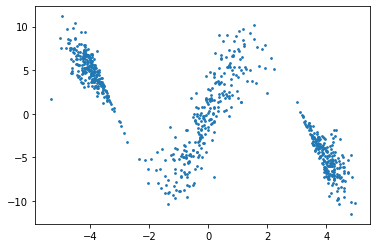

In [22]:
plt.scatter(X_hsc, y_hsc, s=3)
plt.show()

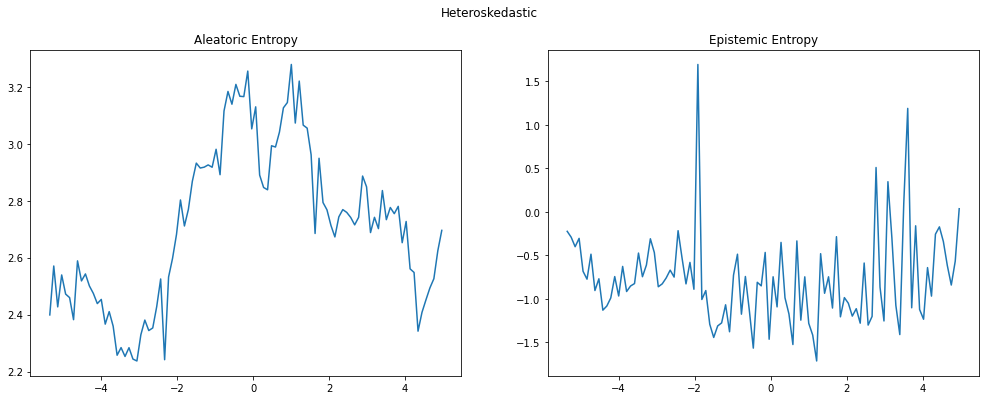

In [25]:
fig, ax = plt.subplots(1,2,figsize=(17,6))
ax[0].plot(x_test_space_small_hsc, hsc_aleatoric_entropy)
ax[0].set_title('Aleatoric Entropy')

ax[1].plot(x_test_space_small_hsc, hsc_epistemic_entropy)
ax[1].set_title('Epistemic Entropy')

plt.suptitle('Heteroskedastic')
plt.show()

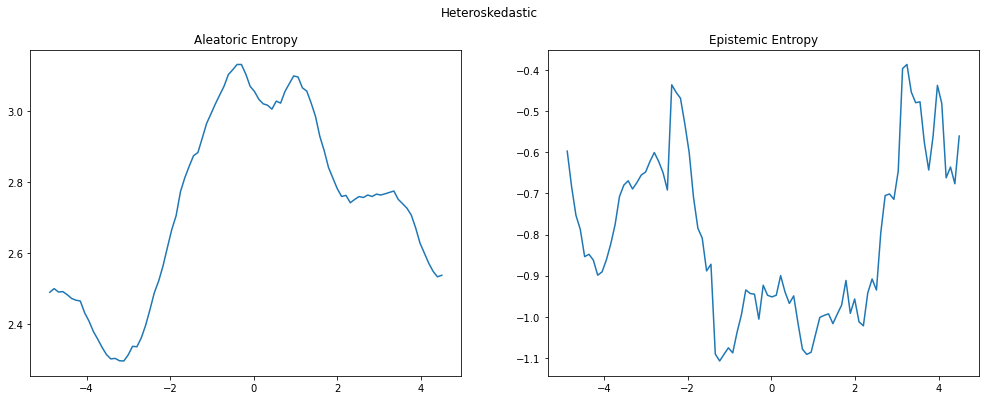

In [62]:
window=10

fig, ax = plt.subplots(1,2,figsize=(17,6))
ax[0].plot(moving_average(x_test_space_small_hsc.flatten(),window),
           moving_average(hsc_aleatoric_entropy.flatten(),window))
ax[0].set_title('Aleatoric Entropy')

ax[1].plot(moving_average(x_test_space_small_hsc.flatten(),window),
           moving_average(hsc_epistemic_entropy.flatten(),window))
ax[1].set_title('Epistemic Entropy')

plt.suptitle('Heteroskedastic')
plt.show()

## Bimodal

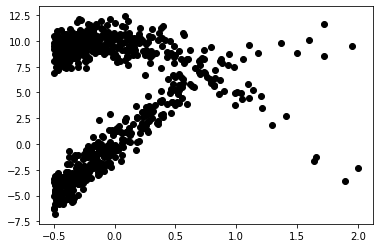

In [42]:
y_bimodal, X_bimodal = generate_regression_outputs(type='bimodal')

In [43]:
X_test_bimodal = np.linspace(min(X_bimodal), max(X_bimodal), 100).reshape((1, -1))

In [44]:
# Parameters
gamma_bimodal = 1
sigma_bimodal = 1

architecture_bimodal = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma_bimodal],
             'sigma':[sigma_bimodal]}

bnn_lv_bimodal = BNN_LV_pymc3(architecture=architecture_bimodal)

bnn_lv_bimodal.fit(X_bimodal, y_bimodal, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 177.41339637459362; gradient mag: 394.520978578978
Iteration 500 lower bound 30.558323372281492; gradient mag: 0.1954501572649032
Iteration 1000 lower bound 30.498246932695668; gradient mag: 0.20053360210759225
Iteration 1500 lower bound 30.463277105902776; gradient mag: 0.4703883089144857
Iteration 2000 lower bound 30.42372836895873; gradient mag: 0.46834291826341345
Iteration 2500 lower bound 30.373800988283854; gradient mag: 1.4041369389802192
Iteration 3000 lower bound 30.32436496430529; gradient mag: 1.6136181963994911
Iteration 3500 lower bound 30.302883525626065; gradient mag: 1.1802120832708691
Iteration 4000 lower bound 30.29683254008843; gradient mag: 1.3428511761773392
Iteration 4500 lower bound 30.296650065439742; gradient mag: 2.188575084008085


In [45]:
bimodal_samples_w = np.load('bimodal/bimodal_withlv_w.npy')

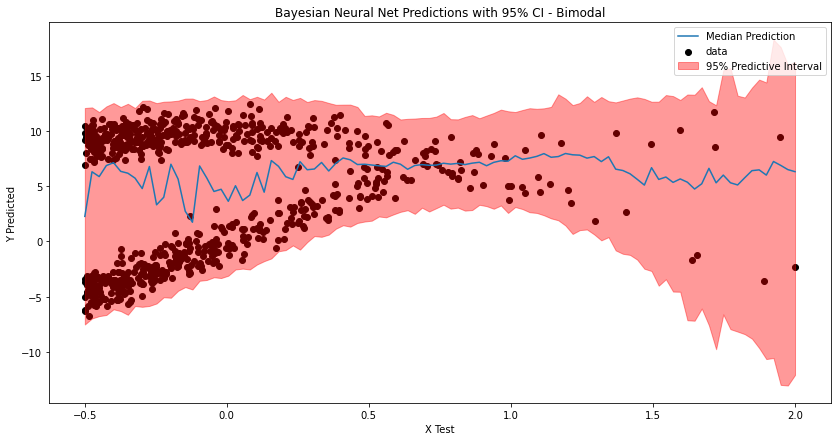

In [46]:
plot_posterior_pred(bnn_lv_bimodal, X_bimodal, y_bimodal, X_test_bimodal, bimodal_samples_w)

## Decompositions

In [47]:
x_test_space_bimodal = np.linspace(min(X_bimodal), max(X_bimodal), N)
x_test_space_small_bimodal = np.linspace(min(X_bimodal), max(X_bimodal), N2)
w_random_samples_bimodal = bimodal_samples_w[np.random.choice(bimodal_samples_w.shape[0], S), :].squeeze(1)

In [48]:
bimodal_epistemic_entropy, bimodal_aleatoric_entropy = decompose(bnn_lv_bimodal,
                                                                 x_test_space_bimodal,
                                                                 x_test_space_small_bimodal,
                                                                 w_random_samples_bimodal,
                                                                 S, N, N2, D)

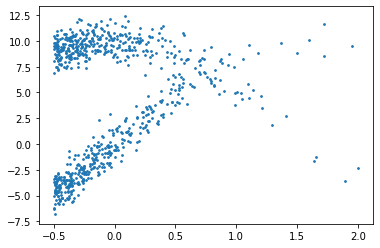

In [49]:
plt.scatter(X_bimodal, y_bimodal, s=3)
plt.show()

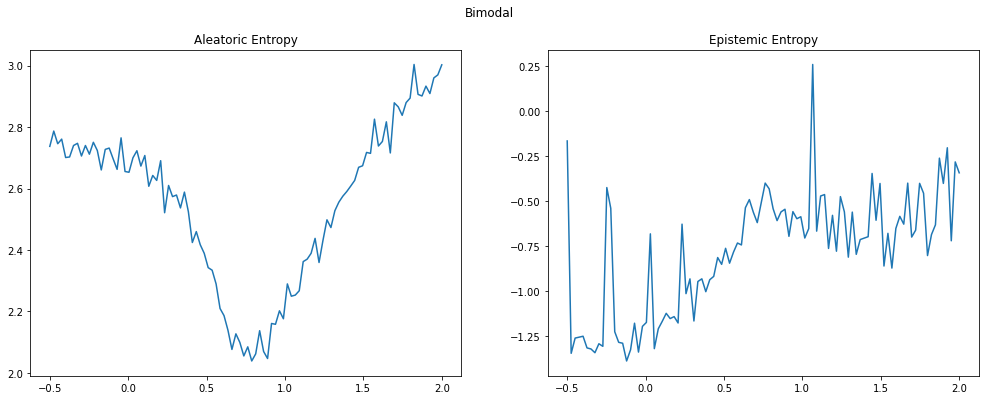

In [50]:
fig, ax = plt.subplots(1,2,figsize=(17,6))
ax[0].plot(x_test_space_small_bimodal, bimodal_aleatoric_entropy)
ax[0].set_title('Aleatoric Entropy')

ax[1].plot(x_test_space_small_bimodal, bimodal_epistemic_entropy)
ax[1].set_title('Epistemic Entropy')
plt.suptitle('Bimodal')
plt.show()

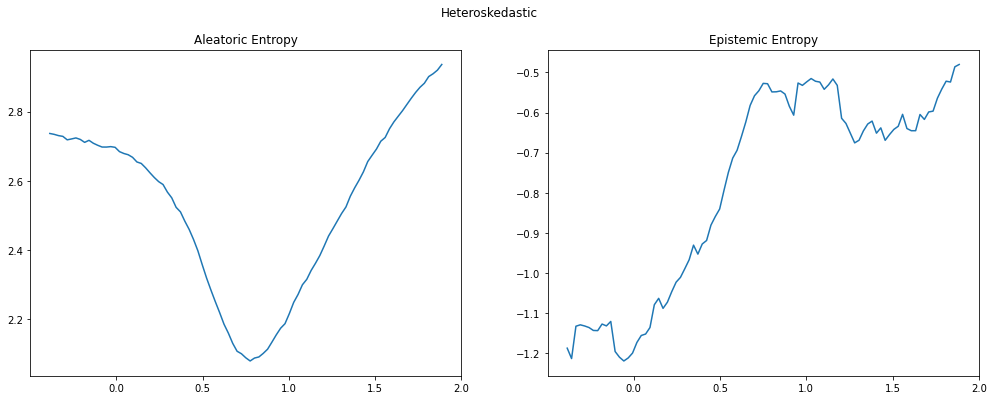

In [63]:
window=10

fig, ax = plt.subplots(1,2,figsize=(17,6))
ax[0].plot(moving_average(x_test_space_small_bimodal.flatten(),window),
           moving_average(bimodal_aleatoric_entropy.flatten(),window))
ax[0].set_title('Aleatoric Entropy')

ax[1].plot(moving_average(x_test_space_small_bimodal.flatten(),window),
           moving_average(bimodal_epistemic_entropy.flatten(),window))
ax[1].set_title('Epistemic Entropy')

plt.suptitle('Heteroskedastic')
plt.show()